In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    %pip install bmtool &> /dev/null

In [2]:
import numpy as np
from scipy import signal as ss
import matplotlib.pyplot as plt
from bmtool.analysis.lfp import fit_fooof, calculate_plv, calculate_ppc1

def calculate_ppc1_spectrum(spike_times, lfp_signal, fs, freq_range, freq_step, bandwidth=4):
    """
    Calculate PPC1 across a range of frequencies.
    
    Parameters:
    -----------
    spike_times : array_like
        Array of spike times in seconds
    lfp_signal : array_like
        Local field potential time series
    fs : float
        Sampling frequency of the LFP signal in Hz
    freq_range : tuple
        Frequency range (min_freq, max_freq) to analyze in Hz
    freq_step : float
        Step size between consecutive frequency bands in Hz
    bandwidth : float, optional
        Width of each frequency band in Hz, default is 4 Hz
    
    Returns:
    --------
    frequencies : array
        Center frequencies of each band
    ppc1_values : array
        PPC1 values for each frequency band
    """
    min_freq, max_freq = freq_range
    
    # Create frequency bands
    center_freqs = np.arange(min_freq, max_freq, freq_step)
    ppc1_values = []
    
    for freq in center_freqs:
        band_min = max(1, freq - bandwidth/2)  # Avoid negative frequencies
        band_max = freq + bandwidth/2
        band_middle = (band_min + band_max)/2
        ppc1, _ = calculate_ppc1(spike_times=spike_times, lfp_signal=lfp_signal,spike_fs=1, lfp_fs=fs, method='wavelet',freq_of_interest=band_middle)
        ppc1_values.append(ppc1)
    
    return center_freqs, np.array(ppc1_values)

def plot_plv_spectrum(beta_spike_times,gamma_spike_times):
    bin_size = 0.001 # 1ms bins to get 1000 Hz
    bins = np.arange(0, 20 + bin_size, bin_size)
    bin_centers = bins[:-1] + bin_size/2

    spike_counts, _ = np.histogram(gamma_spike_times, bins=bins)
    gamma_rate = spike_counts / bin_size

    spike_counts, _ = np.histogram(beta_spike_times, bins=bins)
    beta_rate = spike_counts / bin_size
    
    freqs = [5,15,30,40,50,60,70,80]
    gamma_spikes_LFP_PLV = []
    beta_spikes_LFP_PLV = []


    for freq in freqs:
        gamma_spikes_LFP_PLV.append(calculate_plv(gamma_rate,lfp,fs=1000,freq_of_interest=freq))
        beta_spikes_LFP_PLV.append(calculate_plv(beta_rate,lfp,fs=1000,freq_of_interest=freq))
        
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(freqs,beta_spikes_LFP_PLV,'o-', linewidth=2,label="Beta Synchronized spikes")
    ax.plot(freqs,gamma_spikes_LFP_PLV,'o-', linewidth=2,label="Gamma Synchronized spikes")
    ax.fill_between(freqs, 0, beta_spikes_LFP_PLV, alpha=0.3)
    ax.fill_between(freqs, 0, gamma_spikes_LFP_PLV, alpha=0.3)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Phase locking value')
    plt.grid(True)
    plt.title("Phase Locking Value over Different Frequencies")
    plt.show()

def plot_ppc1_spectrum(frequencies, ppc1_values, ax=None, title="PPC1 Frequency Spectrum",annotate=False,label=None):
    """
    Plot PPC1 values across frequencies.
    
    Parameters:
    -----------
    frequencies : array
        Center frequencies of each band
    ppc1_values : array
        PPC1 values for each frequency band
    ax : matplotlib.axes.Axes, optional
        Axes to plot on. If None, a new figure and axes will be created
    title : str, optional
        Title for the plot
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(frequencies, ppc1_values, 'o-', linewidth=2,label=label)
    ax.fill_between(frequencies, 0, ppc1_values, alpha=0.3)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PPC1')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    
    # Highlight maximum PPC1 value
    max_idx = np.argmax(ppc1_values)
    max_freq = frequencies[max_idx]
    max_ppc1 = ppc1_values[max_idx]
    
    if annotate:
        ax.plot(max_freq, max_ppc1, 'ro', markersize=8)
        ax.annotate(f'Peak: {max_freq:.1f} Hz\nPPC1: {max_ppc1:.3f}',
                    xy=(max_freq, max_ppc1),
                    xytext=(max_freq+5, max_ppc1),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                    fontsize=10)
    
    return ax

def generate_data():
    """
    Generate simulated LFP and two separate spike trains:
    1. One synchronized with beta oscillations
    2. One synchronized with gamma oscillations
    """
    # Simulation parameters
    fs = 1000  # 1 kHz sampling rate
    duration = 20  # 20 seconds
    t = np.arange(0, duration, 1/fs)
    
    # Define oscillation frequencies
    beta_freq = 15  # Hz
    gamma_freq = 40  # Hz
    
    # Create a simulated LFP with multiple frequency components
    lfp = (0.5 * np.sin(2 * np.pi * gamma_freq * t) + 0.2 * np.sin(2 * np.pi * beta_freq * t) +  0.3 * np.random.randn(len(t)))
    
    # Generate phase information for each frequency
    beta_phase = np.angle(ss.hilbert(np.sin(2 * np.pi * beta_freq * t)))
    gamma_phase = np.angle(ss.hilbert(np.sin(2 * np.pi * gamma_freq * t)))
    
    # Generate beta-synchronized spikes
    # Strong preference for specific beta phase, weak response to gamma
    beta_spike_probability = (0.8 * (1 + np.cos(beta_phase - np.pi/4)) + 
                             0.1 * (1 + np.cos(gamma_phase - np.pi/3)))
    
    beta_spike_train = np.random.rand(len(t)) < beta_spike_probability * 0.02
    beta_spike_times = t[beta_spike_train]
    
    # Generate gamma-synchronized spikes
    # Strong preference for specific gamma phase, weak response to beta
    gamma_spike_probability = (0.1 * (1 + np.cos(beta_phase - np.pi/4)) + 
                              0.8 * (1 + np.cos(gamma_phase - np.pi/3)))
    
    gamma_spike_train = np.random.rand(len(t)) < gamma_spike_probability * 0.02
    gamma_spike_times = t[gamma_spike_train]
    
    print(f"Generated {len(beta_spike_times)} beta-synchronized spikes")
    print(f"Generated {len(gamma_spike_times)} gamma-synchronized spikes")
    
    # Calculate PPC1 spectrum for beta-synchronized spikes
    freq_range = (2, 80)  # 2-80 Hz
    freq_step = 5  # 2 Hz steps
    bandwidth = 10  # 4 Hz bandwidth
    
    beta_freqs, beta_ppc1s = calculate_ppc1_spectrum(
        beta_spike_times, lfp, fs, freq_range, freq_step, bandwidth
    )
    
    # Calculate PPC1 spectrum for gamma-synchronized spikes
    gamma_freqs, gamma_ppc1s = calculate_ppc1_spectrum(
        gamma_spike_times, lfp, fs, freq_range, freq_step, bandwidth
    )

    return lfp, beta_spike_times, gamma_spike_times, beta_freqs, beta_ppc1s, gamma_freqs, gamma_ppc1s


lfp, beta_spike_times, gamma_spike_times, beta_freqs, beta_ppc1s, gamma_freqs, gamma_ppc1s = generate_data()

Generated 345 beta-synchronized spikes
Generated 365 gamma-synchronized spikes


### We can see the LFP has two bumps at beta and gamma


FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 98 Hz                        
                                 Frequency Resolution is 3.91 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -3.9246, -0.0989                                         
                                                                                                  
                             

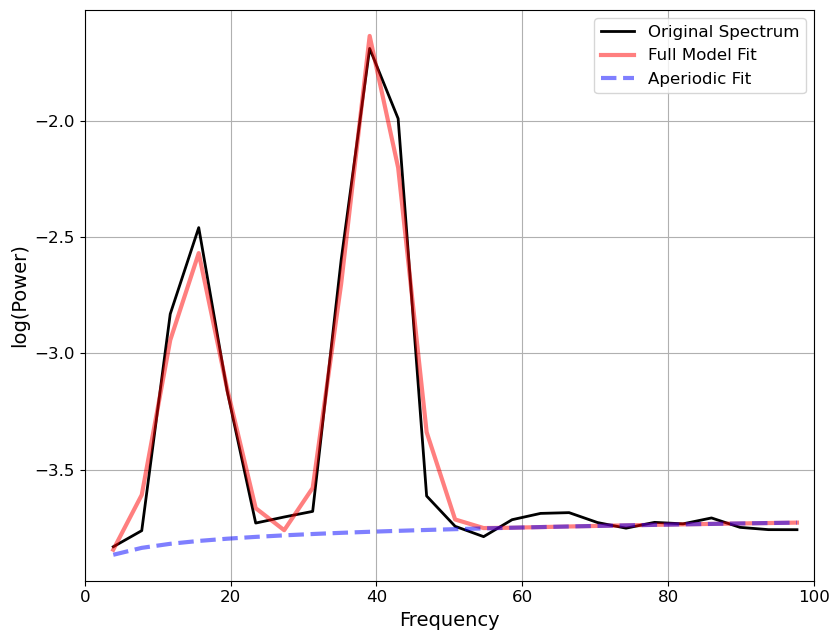

In [3]:
hz, pxx = ss.welch(x=lfp,fs=1000)
results = fit_fooof(f=hz,pxx=pxx,plot=True,report=True,freq_range=[0,100],plt_log=False,plt_range=[0,100],dB_threshold=1.0)

### We can then plot the pairwise phase consistency to see which our of cell populations are entrained at which frequency

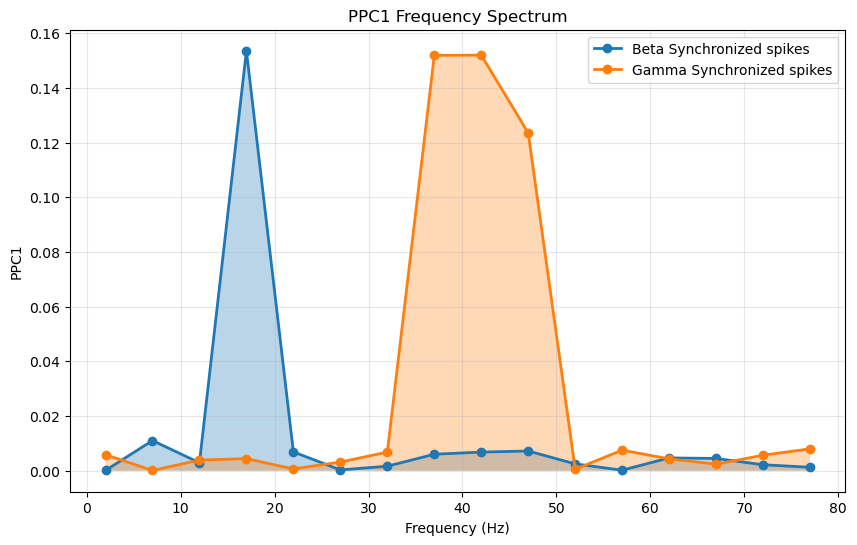

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_ppc1_spectrum(frequencies=beta_freqs,ppc1_values=beta_ppc1s,ax=ax,label='Beta Synchronized spikes')
plot_ppc1_spectrum(frequencies=gamma_freqs,ppc1_values=gamma_ppc1s,ax=ax,label='Gamma Synchronized spikes')
plt.legend()
plt.show()


### we can also compute the phase locking value are these two cell populations and get a very similar plot. Not i used a different techique to filter the signal and slighly different frequecies but the pattern in the graph is similar

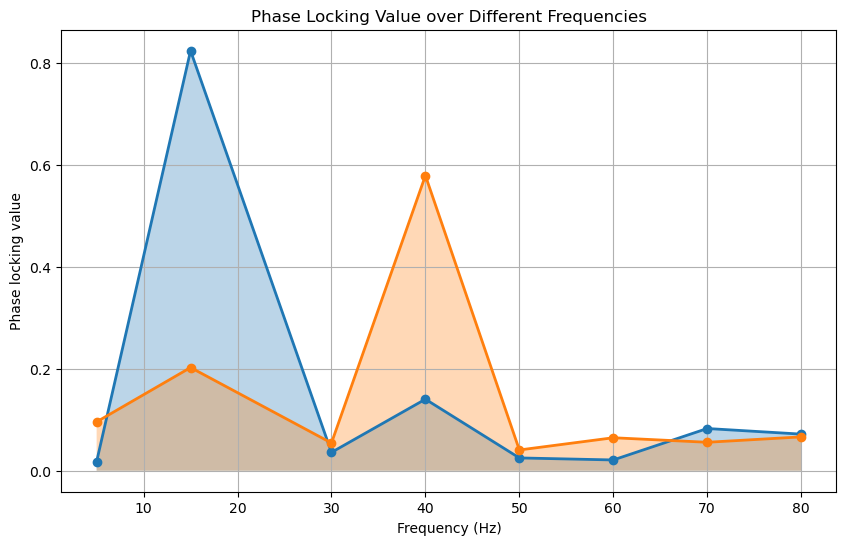

In [5]:
plot_plv_spectrum(beta_spike_times=beta_spike_times,gamma_spike_times=gamma_spike_times)